Neural networks have not always been popular, partly because they were, and still are in some cases, computationally expensive and partly because they did not seem to yield better results when compared with simpler methods such as support vector machines (SVMs).

In [110]:
# https://datascienceplus.com/fitting-neural-network-in-r/
# /home/larisa/anaconda3/bin/jupyter notebook
require(nnet)

rm(list=ls())
filled_path <- "C:/Users/IVA/Apps/R/"
filled_path <- "/home/larisa/Dropbox/Apps/"
setwd(filled_path); getwd()
cli_dataset <-read.table("1967.cli", header=FALSE, sep="")
names(cli_dataset) <- c("day", "month", "year", "prec", "temp");
cli_dataset[cli_dataset$prec == -9999, 4] <- NA
cli_dataset[cli_dataset$temp == -9999, 5] <- NA

# First we need to check that no datapoint is missing, otherwise we need to fix the dataset.
prec_vector <- cli_dataset[, 4]; temp_vector <- cli_dataset[, 5]
summary(prec_vector); summary(temp_vector)
apply(data.frame(prec_vector, temp_vector), 2, function(x) sum(is.na(x)))


[1] "/home/larisa/Dropbox/Apps"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   0.000   9.726   5.000 191.000      33 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -542.0  -346.5   -38.5  -109.9   105.0   251.0      33 

prec_vector temp_vector 
         33          33

In [111]:
# Preparing to fit the neural network
# I chose to use the min-max method and scale the data in the interval [0,1]
data <- na.omit(data.frame(time= (1: length(prec_vector)), prec=prec_vector))
index <- sample(1:nrow(data),round(0.75*nrow(data)))
summary(data)
str(index)

      time            prec        
 Min.   :  1.0   Min.   :  0.000  
 1st Qu.:101.8   1st Qu.:  0.000  
 Median :192.5   Median :  0.000  
 Mean   :190.7   Mean   :  9.726  
 3rd Qu.:279.2   3rd Qu.:  5.000  
 Max.   :365.0   Max.   :191.000  

 int [1:249] 236 58 309 289 166 320 91 313 135 27 ...


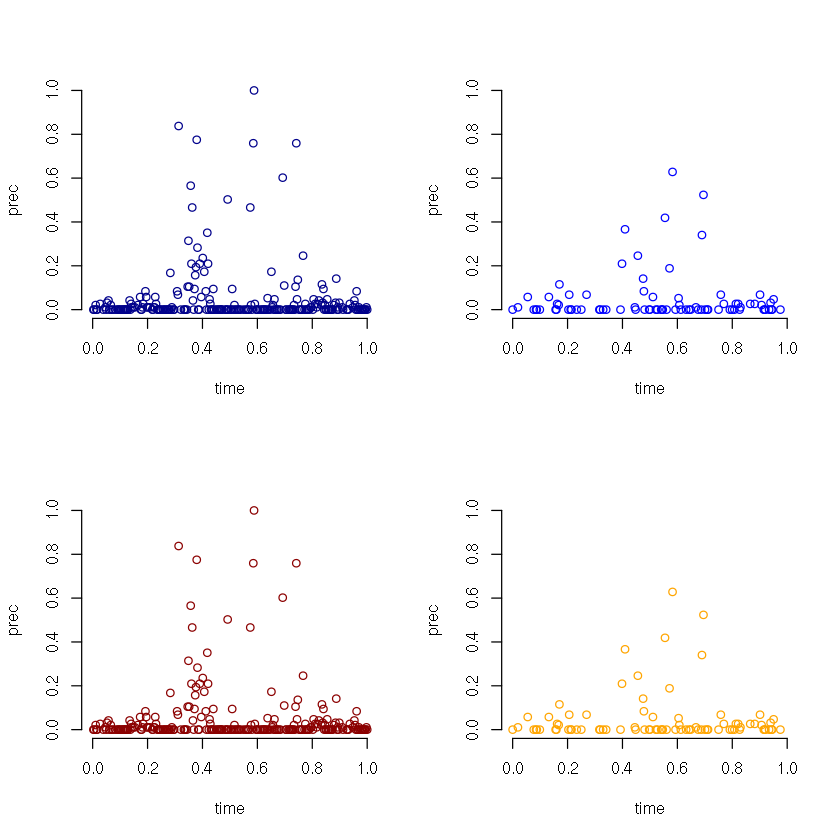

In [112]:
maxs <- apply(data, 2, max) 
mins <- apply(data, 2, min)
#!!! Note that scale returns a matrix that needs to be coerced into a data.frame
scaled <- as.data.frame(scale(data, center = mins, scale = maxs - mins))

train_ <- scaled[index,]
test_ <- scaled[-index,]
# https://www.r-bloggers.com/what-a-nice-looking-scatterplot/
par(mfrow=c(2,2))
plot(train_, frame.plot=FALSE, col="darkblue", ylim=c(0,1), xlim=c(0,1))
plot(test_, frame.plot=FALSE, col="blue", ylim=c(0,1), xlim=c(0,1))
plot(train_, frame.plot=FALSE, col="darkred", ylim=c(0,1), xlim=c(0,1))
plot(test_, frame.plot=FALSE, col="orange", ylim=c(0,1), xlim=c(0,1))

In [113]:
nnet.fit <- nnet(prec~ ., data=train_, size=7, linout=TRUE, maxit=450, trace=F, 
                 skip=TRUE, MaxNWts=10000, abstol = 1.0e-4, reltol = 1.0e-8)
# summarize the fit
print(summary(nnet.fit))

a 1-7-1 network with 23 weights
options were - skip-layer connections  linear output units 
 b->h1 i1->h1 
  5.15 -11.77 
 b->h2 i1->h2 
-10.01  25.23 
 b->h3 i1->h3 
  2.67  -6.40 
 b->h4 i1->h4 
 -4.63  -1.85 
 b->h5 i1->h5 
 -0.68  -1.51 
 b->h6 i1->h6 
-12.52  31.06 
 b->h7 i1->h7 
 11.05 -21.87 
  b->o  h1->o  h2->o  h3->o  h4->o  h5->o  h6->o  h7->o  i1->o 
 -0.70   3.44   5.06  -2.11   2.39   0.36  -3.85  -0.88  -0.51 


In [114]:
# make predictions
x <- data.frame(time=test_[, 1])
predictions <- predict(nnet.fit, x, type="raw")
summary(predictions)
# summarize accuracy
y <- test_[, 2]
mse <- mean((y - predictions)^2, na.rm = T)
cat("MSE = ", mse, "\n")

       V1          
 Min.   :0.005399  
 1st Qu.:0.011981  
 Median :0.033063  
 Mean   :0.047347  
 3rd Qu.:0.074469  
 Max.   :0.184254  

MSE =  0.01289593 


In [115]:
abs_predict <- function(x){
  if(x < 0) return(0)
  else return(x)
}
pred_src<-data.frame(prec_predict = sapply(predictions[, 1], abs_predict))

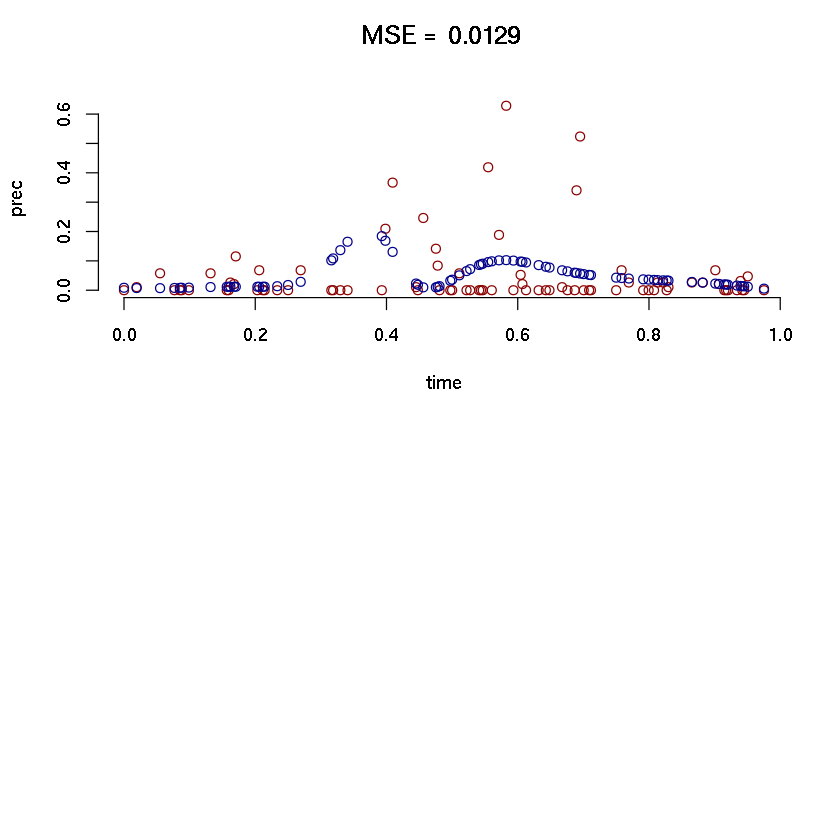

In [124]:
#plot.new()
par(mfrow=c(2,1))
plot(test_, col = "darkred", main=paste("MSE = ", round(mse,4), "\n"), frame.plot=FALSE)
res_src <- data.frame(time=test_[, 1], prec=pred_src[, 1])
points(res_src, col="darkblue")